In [1]:
# Standard Libraries
import pandas as pd
import re
import string
import os

# Natural Language Processing Libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Machine Learning Libraries
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

# Topic Modeling Libraries
import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models import LdaModel

# Visualisation libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Downloading NLTK Packages
#nltk.download(['stopwords', 'wordnet', 'punkt'])

# Define Stop Words
stop_words = list(stopwords.words('english'))

# Add Custom Stop Words
new_words = ['british', 'airway', 'company', 'airline', 'flight', 'heathrow', 'service', 'london',
             'business', 'economy', 'customer', 'passenger', 'hour', 'minute']
stop_words.extend(new_words)


In [2]:
def load_data() -> pd.DataFrame:
  """
  this fucnction loads the data from csv file and samples 20% of the data
  """
  data = pd.read_csv(os.path.join("..", "data", 
                                      'reviews.csv'))
  data = data[['ReviewBody']]
  data = data.sample(frac=0.20, random_state=42).reset_index(drop=True)  
  return data


In [3]:
df_reviews = load_data()

In [4]:
def preprocess_text(text : str) -> list:
    """
    This function prepares the text data, conducting the following steps:
    1) Removal of text in sqaure brackets
    2) Removal of words containing numbers
    3) Removal of emojis
    4) Removal of extra spaces and newline characters
    5) Tokenization
    6) Lemmatization
    7) Removal of stopwords
    8) Removal of punctuation
    9) Removal of names
    """
    # remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)
    # remove special characters
    text = re.sub(r'[^a-zA-Z0-9 ]', '', text)
    # Remove words containing numbers
    text = re.sub(r'\b\w*\d\w*\b', '', text)
    # Remove emojis
    text = text.encode('ascii', 'ignore').decode('ascii')
    # Remove extra spaces and newline characters
    text = re.sub(r'\s+', ' ', text).strip()
    # Tokenize the text
    tokens = word_tokenize(text.lower())

    # Initialize WordNet lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Lemmatize tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stop words and punctuation
    processed_tokens = [token for token in lemmatized_tokens if token.lower() not in stop_words and token not in string.punctuation and len(token)>5]
    return processed_tokens

In [5]:
df_reviews['ReviewBody'] = df_reviews.ReviewBody.apply(
    lambda x: preprocess_text(x))  # apply the function

In [6]:
def apply_lda_with_bag_of_words(df_reviews:pd.DataFrame) -> pd.DataFrame:
    """
    This function applies LDA from gensim with bag of words approach. 
    """
    # Map IDs to words to be used as an input for the LDA model using the universal corpous ids
    # this approach uses word counts and word positions
    words = corpora.Dictionary(df_reviews['ReviewBody'])
    
    # Turn each review into a bag of words.
    corpus = [words.doc2bow(doc) for doc in df_reviews['ReviewBody']]
    
    # Apply the LDA model from gensim to establish topics
    lda_bag_of_words_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=words,
        num_topics=6,
        random_state=42,
        update_every=1,
        passes=12,
        alpha='auto'
    )
    
    feature_names_bag_of_words = list(words.values())
    n_top_words = 10
    
    # Initialize a dictionary to store topic words
    topics_dict = {}
    
    for topic_idx, topic in enumerate(lda_bag_of_words_model.get_topics()):
        topic_words = [feature_names_bag_of_words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics_dict[f'Topic {(topic_idx + 1)}'] = topic_words
    
    # Turn the dict into dataframe
    lda_bag_of_words_model_topics_df = pd.DataFrame(topics_dict)
    
    return feature_names_bag_of_words, lda_bag_of_words_model, lda_bag_of_words_model_topics_df


In [7]:
feature_names_bag_of_words,  lda_bag_of_words_model, lda_with_bag_of_words_topics_df = apply_lda_with_bag_of_words(df_reviews)

In [8]:
def visualize_topics(model_method: str, feature_names:list, n_top_words:int) -> None:
    """
    Visualizes topics generated by a topic modeling method using word clouds.
    """
    # Create subplots for each topic
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 8), sharex=True, sharey=True)
    axes = axes.flatten()

    for topic_idx, topic in enumerate(model_method):
        # Generate word cloud for each topic
        wordcloud = WordCloud(background_color="white", colormap="viridis").generate(' '.join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        ax = axes[topic_idx]
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f'Topic {topic_idx + 1}', fontsize=16)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

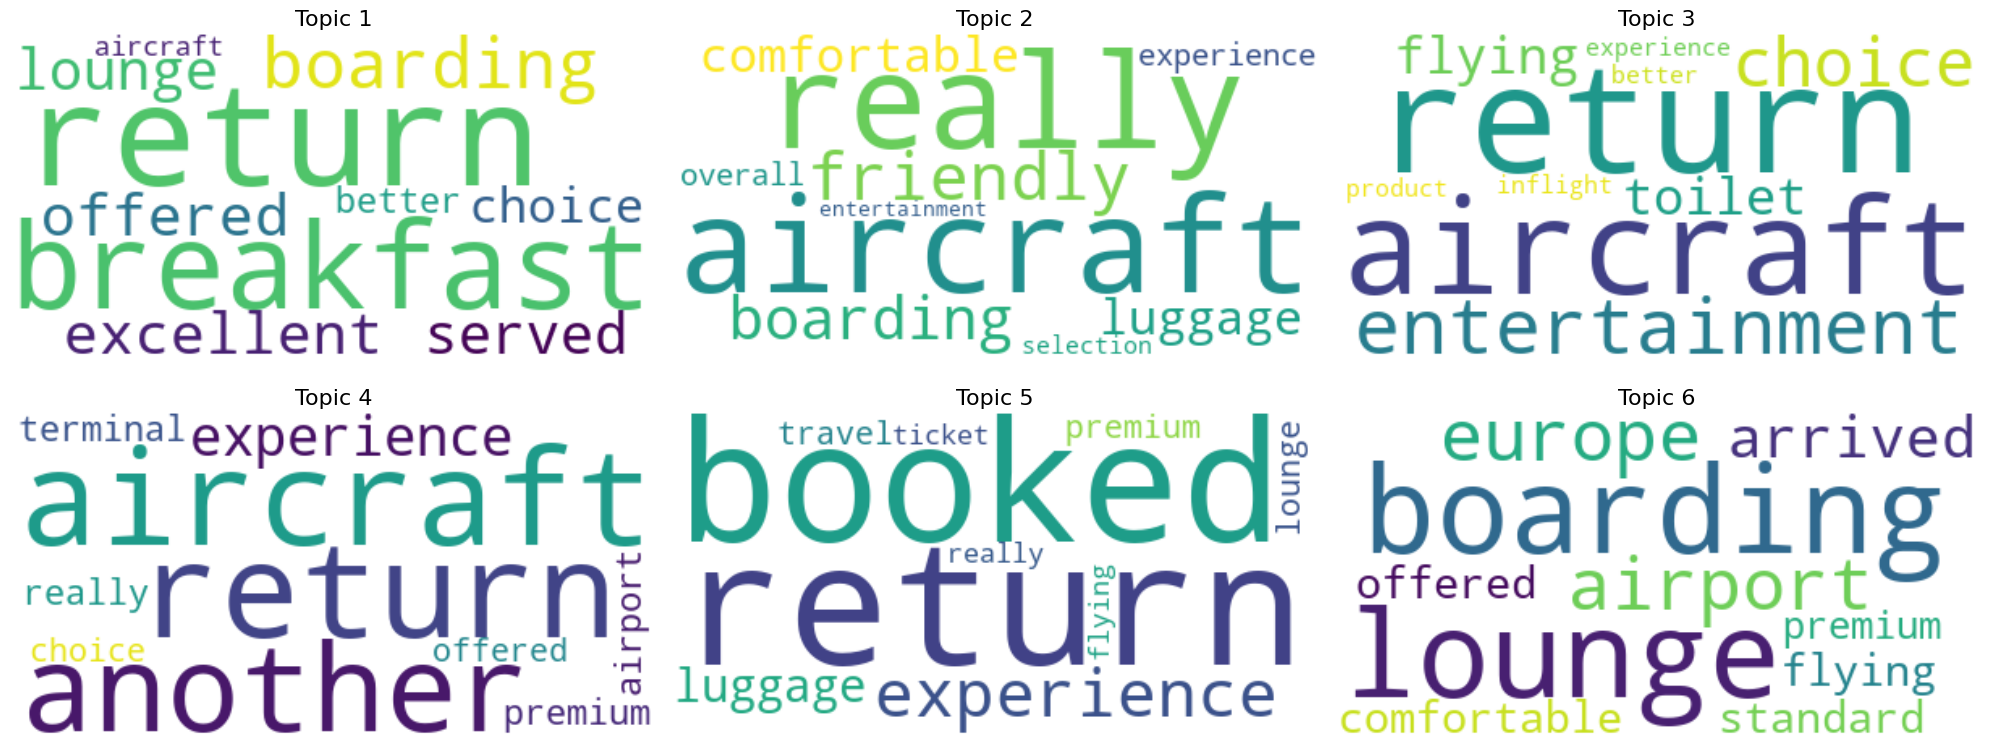

In [9]:
visualize_topics(lda_bag_of_words_model.get_topics(), feature_names_bag_of_words, n_top_words=10)

## Topics from LDA and Bag of Words
1) Food and Baverages
2) Cabin and Luggage
3) Entertaiment
4) Departures and Flights
5) Booking and Lounge experience
6) Lounge and Boarding

In [10]:
def apply_lda_with_tfidf(df_reviews):
    """
    This function applies LDA from scikit-learn with tfidf approach. 
    """
    # Initialize TFIDF
    tfidf = TfidfVectorizer(max_df=.8, min_df=20, max_features=10000)
    # Convert the feedback_answer_tokenized column to a list of strings
    df_reviews['ReviewBody_tokenized'] = df_reviews['ReviewBody'].apply(
    lambda x: ' '.join(x))
    # Fit the TF-IDF vectorizer to the data
    X = tfidf.fit_transform(df_reviews['ReviewBody_tokenized'])
    # Run LDA
    lda_model_with_tfidf = LatentDirichletAllocation(
    n_components=6, random_state=123, learning_method='batch')
    lda_model_with_tfidf.fit_transform(X)
    
    n_top_words = 10
    feature_names_tfidf = tfidf.get_feature_names_out()
    
    # Initialize a dictionary to store topic words
    topics_dict = {}
    
    for topic_idx, topic in enumerate(lda_model_with_tfidf.components_):
        topic_words = [feature_names_tfidf[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics_dict[f'Topic {(topic_idx + 1)}'] = topic_words
    
    # Turn the dict into dataframe
    lda_tfidf_topics_df = pd.DataFrame(topics_dict)
    return feature_names_tfidf, lda_model_with_tfidf, lda_tfidf_topics_df


In [11]:
feature_names_tfidf, lda_model_with_tfidf, lda_tfidf_topics_df = apply_lda_with_tfidf(df_reviews)

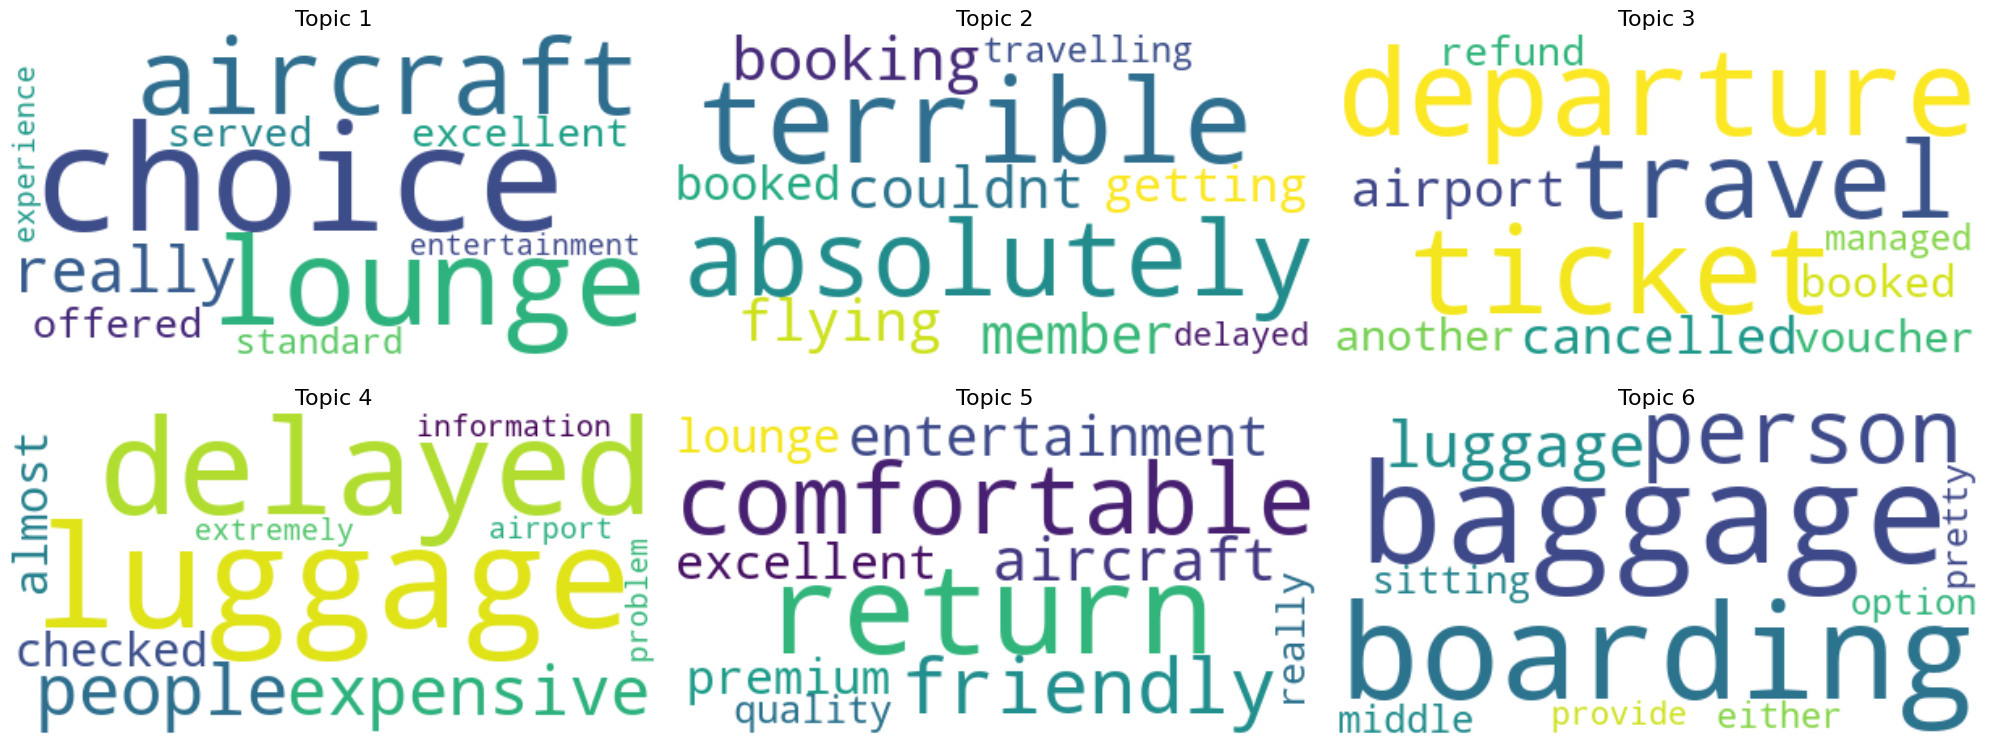

In [12]:
visualize_topics(lda_model_with_tfidf.components_, feature_names_tfidf, n_top_words=10)

## Topics from LDA and TFIDF
1) Lounge Experience
2) Bookings 
3) Departures, Ticketing and Cancellations
4) Luggage Handling and Delays
5) Cabin and Crew Experience
6) Baggage and Boarding

## **Final list of Topics:**

1) Boarding and Crew Experience
2) Entertainment and Food
3) Cabin Comfort and Baggage
4) Lounge Experience
5) Bookings and Refunds
6) Flights and Cancellations